## **Overview**

This is a simple notebook where I use tensorflo model and fit the data.

https://www.tensorflow.org/

We will be working with the [Gluon dataset](https://github.com/rabah-khalek/TF_tutorials/tree/master/PseudoData). A gluon is an elementary particle which gives rise to the strong force, which is the force responsible for binding together the protons and neutrons together in atomic nuclei.

The gluon is exchanged by other elementary particles in the proton and neutron called quarks. These quarks and gluons are more generally referred to as "partons".

Because of certain physical properties governing the partons, they cannot be observed by expermiments as free particles, and their distribution within the proton and neutron cannot be calculated analytically. Instead, their distribution must be inferred from data collected by high energy particle colliders like the Large Hadron Collider (LHC) at CERN.

A fast-moving proton can be described by the parton distribution function (PDF) $f(x)$, which gives the probability density of finding a parton of type $f$ (a specific quark type or gluon) carrying a fraction $x$ of the proton momentum.

The pseudodata used in this tutorial is generated from a gluon distribution function $g(x)$, which was determined in an analysis by the [NNPDF collaboration](http://nnpdf.mi.infn.it), aiming to extract the structure of the proton using contemporary machine learning methods. More specifically, NNPDF determines PDFs using neural networks as a minimally biased modeling tool, trained using Genetic Algorithms (and more recently stochastic gradient descent).

We will consider this pseudodata to be the *truth* that we're trying to *discover*. What we will actually fit is the *smeared truth*, where Gaussian noise is added to simulate more realistic data.

## **Importing the Gluon data set with Pandas**

There are four separate datasets each containing a total of 1000 gluon PDF predictions computed between $x=[x_{min},1]$; where:
- $x_{min} = 10^{-3}$ for `filename1`
- $x_{min} = 10^{-4}$ for `filename2`
- $x_{min} = 10^{-5}$ for `filename3`
- $x_{min} = 10^{-6}$ for `filename4`

Below we use Pandas to import all datapoints from text files.

In [62]:
import tensorflow as tf

In [63]:
import pandas as pd

# The datasets needed are computed by the `ComputeGluon.py` script in PseudoData
filename1='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
filename2='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat'
filename3='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat'
filename4='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat'

# Headers to skip
lines_to_skip = 5

# Defining the columns (cv = central value, sd = standard deviation)
columns=["x", "gluon_cv", "gluon_sd"]

# Change filename1 to another filename for data that extends to lower x
# (see exercises at the bottom of this notebook)
df = pd.read_csv(filename1,
                 sep="\s+",
                 skiprows=lines_to_skip,
                 usecols=[0,1,2],
                 names=columns)


# Sort the split data according to their x values
df = df.sort_values("x")

x_all = df["x"]
y_all = df["gluon_cv"]
yerr_all = df["gluon_sd"]


Let us plot what we loaded

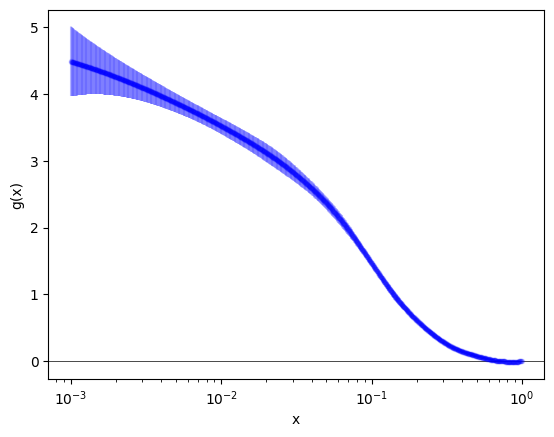

In [68]:
import matplotlib.pyplot as plt


plt.axhline(0,color='k',linewidth=0.5)
plt.errorbar(x_all, y_all, yerr_all, fmt = '.', color='b', alpha=0.15)
plt.xlabel("x")
plt.xscale("log")
plt.ylabel("g(x)")

plt.show()

# Prepare the data by randomizing the central values within sigma

In [65]:
import numpy as np

In [66]:
x_train = x_all.copy()
y_train = y_all.copy()
yerr_train = yerr_all.copy()

# Add noise to data
np.random.seed(42)
y_train += np.random.normal(0, yerr_train)

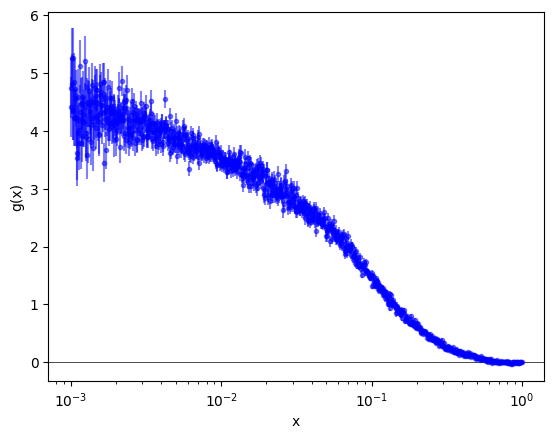

In [67]:
plt.axhline(0,color='k',linewidth=0.5)
plt.errorbar(x_train, y_train, yerr_train, fmt = '.', color='b', alpha=0.5)
plt.xlabel("x")
plt.xscale("log")
plt.ylabel("g(x)")

plt.show()

Now we have to prepare the data for the training

Batch normalization helps achieve better results: https://www.pinecone.io/learn/batch-layer-normalization/

Batch normalization normalizes each feature independently across the mini-batch. Layer normalization normalizes each of the inputs in the batch independently across all features.
As batch normalization is dependent on batch size, it’s not effective for small batch sizes. Layer normalization is independent of the batch size, so it can be applied to batches with smaller sizes as well.
Batch normalization requires different processing at training and inference times. As layer normalization is done along the length of input to a specific layer, the same set of operations can be used at both training and inference times.

In [69]:
from tensorflow import keras

In [108]:
def model_builder(inputs=1, outputs=1):
    # Create a sequential model
    model = keras.Sequential()

    # Flatten the layers
    model.add(keras.layers.Flatten())

    # 1st hidden layer that gets the input
    model.add(keras.layers.Dense(units=8, activation='sigmoid', input_dim=inputs))
    # add LayerNormalization after activations in the previous layer
    model.add(keras.layers.LayerNormalization(axis=1))

    # 2nd hidden layer
    model.add(keras.layers.Dense(units=42, activation='sigmoid'))
    # add LayerNormalization after activations in the previous layer
    model.add(keras.layers.LayerNormalization(axis=1))

    # add output layer
    model.add(keras.layers.Dense(outputs, activation='linear'))


    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='mse')

    return model


In [109]:
# create the model
model = model_builder()

# Perform the fit (I convert dataframe to tensor in order to speed up a little).
# The same will work with x=x_train, y=_ytrain
history = model.fit(x=tf.convert_to_tensor(x_train),
                    y=tf.convert_to_tensor(y_train),
                    epochs=300,
                    validation_split=0.2,
                    batch_size=10)
#history = model.fit(x=x_train,
#                    y=y_train,
#                    epochs=30,
#                    validation_split=0.2,
#                    batch_size=10)

Epoch 1/300
80/80 [==============================] - 2s 7ms/step - loss: 1.3152 - val_loss: 0.0761
Epoch 2/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0735 - val_loss: 0.0092
Epoch 3/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0654 - val_loss: 0.0141
Epoch 4/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0599 - val_loss: 0.0029
Epoch 5/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0575 - val_loss: 0.0024
Epoch 6/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0026
Epoch 7/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.0013
Epoch 8/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0028
Epoch 9/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0175
Epoch 10/300
80/80 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0057
Epoch 11/

In [110]:
# summary of our model
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (10, 1)                   0         
                                                                 
 dense_33 (Dense)            (10, 8)                   16        
                                                                 
 layer_normalization_22 (Lay  (10, 8)                  16        
 erNormalization)                                                
                                                                 
 dense_34 (Dense)            (10, 42)                  378       
                                                                 
 layer_normalization_23 (Lay  (10, 42)                 84        
 erNormalization)                                                
                                                                 
 dense_35 (Dense)            (10, 1)                 

Let us see how predictions worked

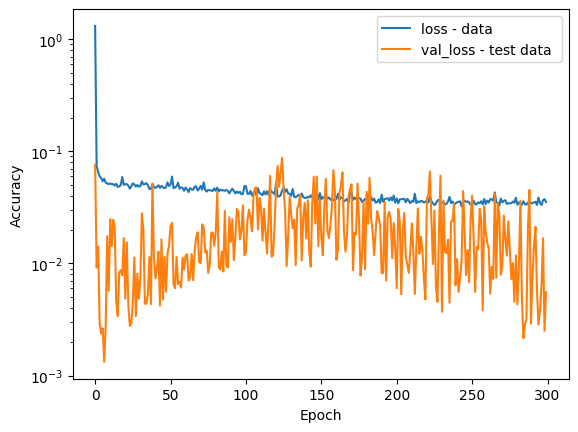

In [111]:
plt.plot(history.history['loss'], label='loss - data')
plt.plot(history.history['val_loss'], label = 'val_loss - test data ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yscale('log')
#plt.ylim([0., 0.1])
plt.legend(loc='best')

Let us see if we can now predict something

32/32 [==============================] - 0s 1ms/step


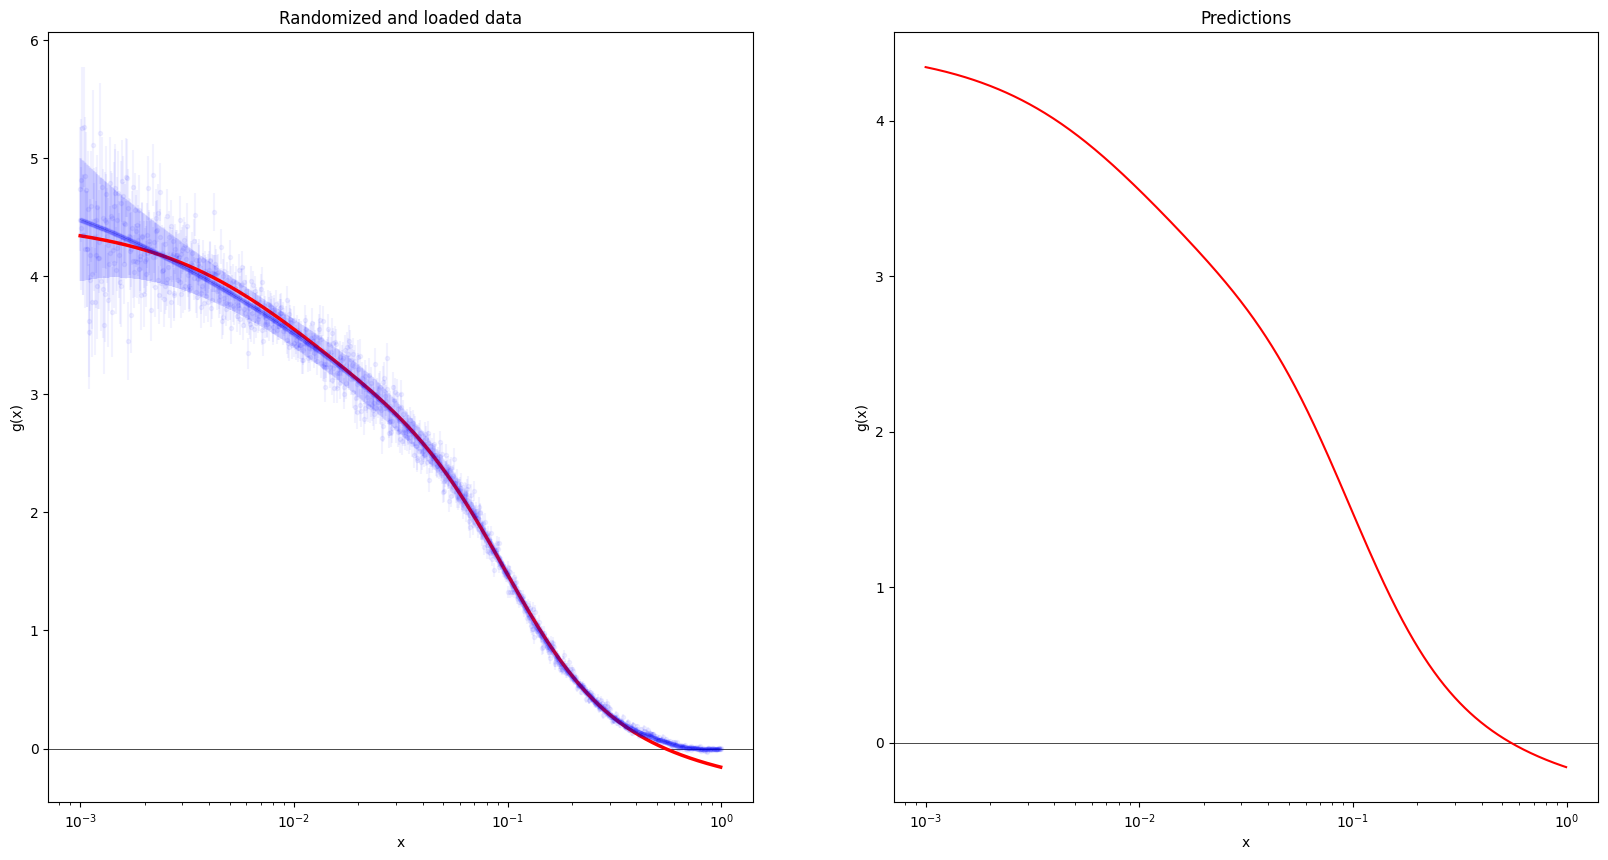

In [112]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].axhline(0,color='k',linewidth=0.5)
ax[0].plot(x_all,y_all,color='darkblue',label='t', lw=0.1)
ax[0].errorbar(x_all,y_all, yerr_all, fmt = '.', color='b', alpha=0.05)
ax[0].errorbar(x_train,y_train, yerr_train, fmt = '.', color='b', alpha=0.05)
ax[0].set_title("Randomized and loaded data")
ax[0].set_xscale("log")
ax[0].set_xlabel("x")
ax[0].set_ylabel("g(x)")

  # Predictions
x_pred = x_all.to_numpy()
y_pred = model.predict(x_all).flatten() #Flatten the results in order to plot them


ax[0].plot(x_pred, y_pred, color='r', linewidth = 2.5)

# Just predictions
ax[1].axhline(0,color='k',linewidth = 0.5)
ax[1].plot(x_pred, y_pred, color='r', alpha=1)
ax[1].set_title("Predictions")
ax[1].set_xscale("log")
ax[1].set_xlabel("x")
ax[1].set_ylabel("g(x)")

plt.show()




---

